# Gradient Descent Construction

In [85]:
# %pip install -q --progress-bar off d2l==1.0.0a1.post0 # replace ! with % for jupyter notebook

Ref: https://d2l.ai/chapter_optimization/gd.html

In [86]:
import copy
from abc import ABC, abstractmethod
from typing import Any, Callable, List, Optional, Tuple, TypeVar, Union

import autograd.numpy as np  # import numpy as np
import torch
from autograd import grad
from d2l import torch as d2l

In [87]:
T = TypeVar("T", bound=Union[float, np.ndarray, torch.Tensor])

In [88]:
class Function:
    def __init__(self, f: Callable) -> None:
        self._f = f

    def __call__(self, x: T, *args: Any, **kwargs: Any) -> T:
        # a function returns a scalar float
        fx = self._f(*args, **kwargs)
        return fx


class GradFunction:
    def __init__(self, grad_f: Callable) -> None:
        self._grad_f = grad_f

    def __call__(self, x: T, *args: Any, **kwargs: Any) -> T:
        # grad fn/vector returns an array of vector
        grad_fx = self._grad_f(*args, **kwargs)
        return grad_fx

## Base

In [89]:
# pylint: disable=invalid-name, redefined-outer-name, too-few-public-methods
class Optimizer(ABC):
    """Abstract class for optimizers.
    Currently, you need to define the f and grad_f functions in the constructor.
    """

    def __init__(self, f: Callable, grad_f: Callable, lr: float, **kwargs: Any) -> None:
        self.f = f
        self.grad_f = grad_f
        self.lr = lr
        self.kwargs = kwargs

    @abstractmethod
    def step(
        self,
        weights: T,
        biases: Optional[T] = None,
    ) -> None:
        """Update the weights and biases.

        Args:
            weights (np.ndarray): The weights to update.
            biases (np.ndarray): The biases to update.

        Raises:
            NotImplementedError:
        """
        raise NotImplementedError

## Gradient Descent

In [90]:
class GradientDescent(Optimizer):
    """Gradient descent optimizer."""

    weights_history: List[T]

    def __init__(self, f: Callable, grad_f: Callable, lr: float, **kwargs: Any) -> None:
        super().__init__(f, grad_f, lr, **kwargs)
        self.weights_history = []

    def step(
        self,
        weights: T,
        biases: Optional[T] = None,
    ) -> Tuple[T, T, List[T]]:
        # grad vec at each point
        gradient_vector = self.grad_f(weights)
        weights -= self.lr * gradient_vector

        if biases is not None:
            raise NotImplementedError("Biases are not implemented yet.")

        print(f"weights {weights}, biases {biases}")

        # must use copy if not weights (np array) mutatable:
        # https://tinyurl.com/bdff69by
        self.weights_history.append(copy.copy(weights))
        return weights, biases, self.weights_history


In [91]:
def f(w: T) -> T:  # Objective function
    """f(w) = w^2"""
    return w**2


def grad_f(w: T) -> T:  # Gradient (derivative) of the objective function
    """f'(w) = 2w"""
    return 2 * w

In [92]:
batch_gd = GradientDescent(f=f, grad_f=grad_f, lr=0.2)

In [93]:
initial_weight = 10
initial_bias = None # we ignore bias for simplicity
num_epochs = 10
for epoch in range(num_epochs):
    initial_weight, initial_bias, weights_history = batch_gd.step(
        initial_weight, initial_bias
    )

weights 6.0, biases None
weights 3.5999999999999996, biases None
weights 2.1599999999999997, biases None
weights 1.2959999999999998, biases None
weights 0.7775999999999998, biases None
weights 0.46655999999999986, biases None
weights 0.2799359999999999, biases None
weights 0.16796159999999993, biases None
weights 0.10077695999999996, biases None
weights 0.06046617599999997, biases None


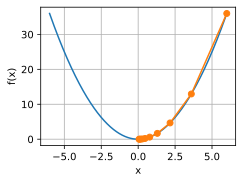

In [94]:
def show_trace(f: Callable, results: List[T]) -> None:
    """Show the trace of variables during optimization."""
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot(
        [f_line, results],
        [[f(x) for x in f_line], [f(x) for x in results]],
        "x",
        "f(x)",
        fmts=["-", "-o"],
    )
    d2l.plt.show()

show_trace(f, weights_history)

## 2D Example

Let the problem be a linear model involving 2 variables:

$$
y = X \beta = \beta_1 x_1 + \beta_2 x_2 
$$

As usual, we know $X$ is the design matrix and we want to find optimal weights for $\beta$.

Later we will use $\beta$ and $w$ interchangeably.

Let the loss function be 

$$
L(\beta_1, \beta_2) = \beta_1^2 + 2\beta_2^2
$$

Then its gradient vector at a point $(\beta_1, \beta_2)$ is:

$$
\nabla L(\beta_1, \beta_2) = \begin{bmatrix} 2\beta_1 \\ 4\beta_2 \end{bmatrix}
$$

In the original text, the author defines the function as follows:

In [95]:
def f_2d(w1, w2):  # Objective function
    return w1 ** 2 + 2 * w2 ** 2

def grad_f_2d(w1, w2):  # Gradient of the objective function
    return (2 * w1, 4 * w2)

We reframe the same functions below to take in only 1 weight vector so autograd can do its work.

In [96]:
def f_2d(w: T) -> T:  # Objective function
    """w = [w1, w2] \\in R^2.
    f(w) = w_1^2 + 2w_2^2"""
    w1, w2 = w[0], w[1]
    return w1**2 + 2 * w2**2


def grad_f_2d(w: T) -> T:  # Gradient (derivative) of the objective function
    """\\nabla f = f'(w) = [2w_1, 4w_2] \\in R^2."""
    return np.asarray([2 * w[0], 4 * w[1]])

In [97]:
initial_weights = np.asarray([-5, -2]).astype('float32') 
initial_biases = None # we ignore bias for simplicity
num_epochs = 20

We can use autograd to directly compute the gradient vector for us.

In [98]:
autograd_f = grad(f_2d)
assert autograd_f(initial_weights).all() == grad_f_2d(initial_weights).all() == np.asarray([10, -8]).all()

In [99]:
batch_gd_no_autograd = GradientDescent(f=f_2d, grad_f=grad_f_2d, lr=0.1)  # no autograd
batch_gd_with_autograd = GradientDescent(f=f_2d, grad_f=autograd_f, lr=0.1)  # autograd

In [100]:
for epoch in range(num_epochs):
    initial_weights, initial_biases, weights_history = batch_gd_no_autograd.step(
        initial_weights, initial_biases
    )

weights [-4.  -1.2], biases None
weights [-3.2  -0.72], biases None
weights [-2.56  -0.432], biases None
weights [-2.0479999 -0.2592   ], biases None
weights [-1.6383998 -0.15552  ], biases None
weights [-1.3107198 -0.093312 ], biases None
weights [-1.0485759 -0.0559872], biases None
weights [-0.8388607  -0.03359232], biases None
weights [-0.6710886  -0.02015539], biases None
weights [-0.53687084 -0.01209324], biases None
weights [-0.42949668 -0.00725594], biases None
weights [-0.34359735 -0.00435357], biases None
weights [-0.27487788 -0.00261214], biases None
weights [-0.2199023  -0.00156728], biases None
weights [-0.17592184 -0.00094037], biases None
weights [-0.14073747 -0.00056422], biases None
weights [-0.11258998 -0.00033853], biases None
weights [-0.09007198 -0.00020312], biases None
weights [-0.07205759 -0.00012187], biases None
weights [-5.7646073e-02 -7.3123170e-05], biases None


In [101]:
initial_weights = np.asarray([-5, -2]).astype('float32') 
initial_biases = None # we ignore bias for simplicity
num_epochs = 20

for epoch in range(num_epochs):
    initial_weights, initial_biases, weights_history = batch_gd_with_autograd.step(
        initial_weights, initial_biases
    )

weights [-4.  -1.2], biases None
weights [-3.2  -0.72], biases None
weights [-2.56  -0.432], biases None
weights [-2.0479999 -0.2592   ], biases None
weights [-1.6383998  -0.15551999], biases None
weights [-1.3107198 -0.093312 ], biases None
weights [-1.0485759 -0.0559872], biases None
weights [-0.8388607  -0.03359232], biases None
weights [-0.6710886  -0.02015539], biases None
weights [-0.53687084 -0.01209324], biases None
weights [-0.42949668 -0.00725594], biases None
weights [-0.34359735 -0.00435356], biases None
weights [-0.27487788 -0.00261214], biases None
weights [-0.2199023  -0.00156728], biases None
weights [-0.17592184 -0.00094037], biases None
weights [-0.14073747 -0.00056422], biases None
weights [-0.11258998 -0.00033853], biases None
weights [-0.09007198 -0.00020312], biases None
weights [-0.07205759 -0.00012187], biases None
weights [-5.7646073e-02 -7.3123156e-05], biases None


In [102]:
weights_history

[array([-4. , -1.2], dtype=float32),
 array([-3.2 , -0.72], dtype=float32),
 array([-2.56 , -0.432], dtype=float32),
 array([-2.0479999, -0.2592   ], dtype=float32),
 array([-1.6383998 , -0.15551999], dtype=float32),
 array([-1.3107198, -0.093312 ], dtype=float32),
 array([-1.0485759, -0.0559872], dtype=float32),
 array([-0.8388607 , -0.03359232], dtype=float32),
 array([-0.6710886 , -0.02015539], dtype=float32),
 array([-0.53687084, -0.01209324], dtype=float32),
 array([-0.42949668, -0.00725594], dtype=float32),
 array([-0.34359735, -0.00435356], dtype=float32),
 array([-0.27487788, -0.00261214], dtype=float32),
 array([-0.2199023 , -0.00156728], dtype=float32),
 array([-0.17592184, -0.00094037], dtype=float32),
 array([-0.14073747, -0.00056422], dtype=float32),
 array([-0.11258998, -0.00033853], dtype=float32),
 array([-0.09007198, -0.00020312], dtype=float32),
 array([-0.07205759, -0.00012187], dtype=float32),
 array([-5.7646073e-02, -7.3123156e-05], dtype=float32)]

In [103]:
def show_trace_2d(f: Callable, results: List[T]) -> None:
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), "-o", color="#ff7f0e")
    x1, x2 = torch.meshgrid(
        torch.arange(-5.5, 1.0, 0.1), torch.arange(-3.0, 1.0, 0.1), indexing="ij"
    )
    d2l.plt.contour(x1, x2, f([x1, x2]), colors="#1f77b4")
    d2l.plt.xlabel("x1")
    d2l.plt.ylabel("x2")
    d2l.plt.show()

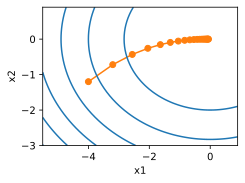

In [104]:
show_trace_2d(f_2d, weights_history)